## Python statistics essential training - 05_06_bayesian

### Bayesian Inference
* We do not make **estimates** of population parameters from the data
* Rather, we maintain **probability distributions** of population distributions, which represent our quantitative belief about their value.
* We start with probability **priors**, and we use **observations** to update them to probability **posteriors**

### Bayes' Theorem

$$P(\theta|y) = \frac{P(y|\theta)* P(\theta)}{P(y)}$$

$y$: Observed data  
$\theta$: Population parameter
$P(\theta|y)$: Posterior  
$P(y|\theta)$ : Likelihood; probability of getting data ($y$) for given population parameter ($\theta$)  
$P(\theta)$: Prior    

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import pymc3 as pm

In [8]:
# I have a coin, but I am suspicious about its fainess. 
# I belive throwing it repeatedly might return heads between 
# 40 and 80% of the times instead of 50%

n = 100 # I flip a coin 100 times
k = 61 # Its heads 61 times

In [10]:
# Creating a pymc3 model.

with pm.Model() as coin_context: # setting up the context 
    # p is actual fraction of the time head comes up for this coin. 
    # prior for it is a uniformly distributed between 0.4 and 0.8.
    p = pm.Uniform('p',0.4,0.8) 
    
    # My actual observation; binomial distribution describes the propability of observing k 
    # events over n trials. Each event has probability p
    y = pm.Binomial('y',observed=k,n=n, p=p)
    
    # Finally we sample the posterior. That is, we ask pymc3 to generate a large set 
    # of population parameters which will be approximately distributed according to the posterior.
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:13<00:00, 3192.19draws/s]


In [11]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.608,0.048,0.517,0.697,0.0,0.0,15284.0,15284.0,15314.0,25721.0,1.0


**mean** is the most probabal value for the biasedness of the coin  
**hpd**: credible interval containing 94% of the probability  

/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc9ef8ddd8>,
      dtype=object)

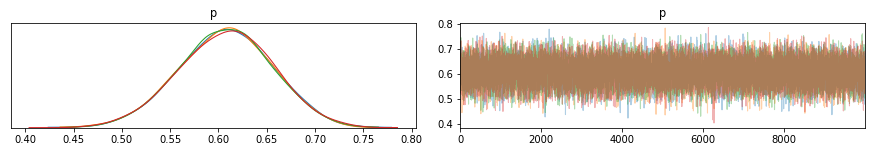

In [12]:
pm.traceplot(trace)

There are two curves because pymc3 ran two separate samplings.  
The plot on the right shows all the values taken on by the parameter p

## Bayesian Stats Modeling

In [13]:
gdata = pd.read_csv('gapminder.csv').query("year == 1985")

In [14]:
gdata.sort_values(by='age5_surviving',inplace=True)

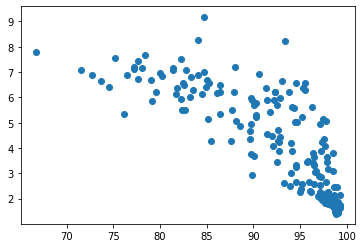

In [16]:
pp.scatter(gdata.age5_surviving,gdata.babies_per_woman)

We need to reproduce this downward trend.  
So we will implement a simple model with an intercept and a main term, a slope for age5_surviving

In [17]:
with pm.Model() as gapminder_context:
    ## Setting priors
    # For intercept we can figure out from the plot that intercept should be about 10 where survival of 65%
    intercept = pm.Uniform('intercept',5,15)  # so a uniform prior between 5 and 15
    
    # For slope, we can again figure out from the plot it should be somewhere around a few tenths
    slope = pm.Uniform('slope',-1,1)

    ## Defining observations
    # Randomly distributed around the model. That is, we allow each
    # data value to have random measurement error with random distribution
    babies = pm.Normal('babies', mu = intercept + slope * (gdata['age5_surviving'] - 65), # in reference to 65%
                       sd = 1, 
                       observed = gdata['babies_per_woman'])
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:26<00:00, 1589.74draws/s]
The acceptance probability does not match the target. It is 0.8914585698013909, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/climbach/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc489657f0>,
      dtype=object)

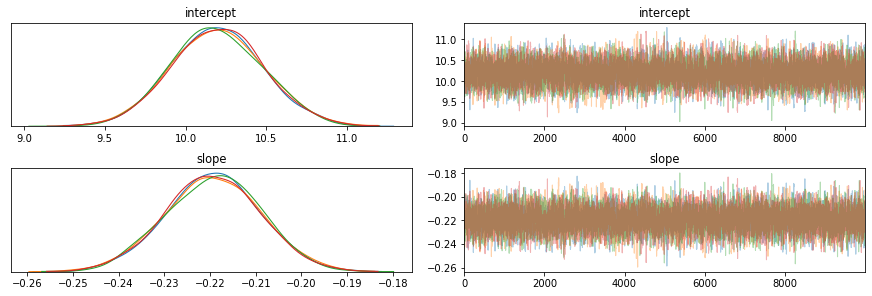

In [18]:
pm.traceplot(trace)

In [25]:
babies = trace['intercept'].mean() + trace['slope'].mean() * (gdata['age5_surviving'] - 65) # Predicted values

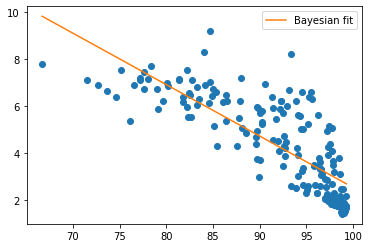

In [29]:
pp.scatter(gdata.age5_surviving,gdata.babies_per_woman)
pp.plot(gdata.age5_surviving,babies,c='C1',label='Bayesian fit')
pp.legend()

Every point in the posterior corresponds to slightly different model. We can visuali it

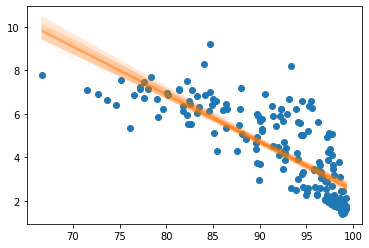

In [33]:
pp.scatter(gdata.age5_surviving,gdata.babies_per_woman)

for ii, intercept, slope in zip(range(100),trace['intercept'][::50],trace['slope'][::50]):
    if ii > 100:
        break
    else:
        babies = intercept + slope * (gdata.age5_surviving - 65)
    
    pp.plot(gdata.age5_surviving,babies,c='C1',alpha=0.05)
    